# Building a Handwritten Digit Classifier with TensorFlow and Android

**NAME:** Emmanuel Kirui

**EMAIL:** kiruiemmanuel4@gmail.com

## Introduction
In this codelab, you will experience the end-to-end process of training a machine learning model to recognize handwritten digit images from the MNIST dataset using TensorFlow and converting it to TensorFlow Lite for mobile app deployment.

**Goal:** By the end of this codelab, you will have an Android app that can recognize handwritten digits that you draw on the screen.

## Step 1: Set Up Your Environment
Before you begin, make sure to install the necessary libraries.

### 1.1 Install Required Libraries
Run the following command in your Google Colab or Jupyter Notebook environment to install TensorFlow and other dependencies.

In [1]:
!pip install tensorflow tensorflow_datasets matplotlib numpy

### 1.2 Import Required Libraries

In [2]:
import math
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Model

## Step 2: Load and Prepare the MNIST Dataset
The MNIST dataset contains 70,000 images of handwritten digits (28x28 pixels). We'll load this dataset and normalize the images for better model performance.

### 2.1 Load the Dataset

In [3]:
# Load MNIST dataset
(full_ds_train_data, ds_test_data), info = tfds.load(
    name='mnist',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True,
)

# Split train set into train (80%) and validation (20%)
train_size = int(0.8 * info.splits['train'].num_examples)
val_size = info.splits['train'].num_examples - train_size

ds_train_data = full_ds_train_data.take(train_size)  # First 80% for training
ds_val_data = full_ds_train_data.skip(train_size)    # Remaining 20% for validation

# Extract dataset information
num_classes = info.features['label'].num_classes
num_train_samples = train_size  # 80% of original train set
num_val_samples = val_size  # 20% of original train set
num_test_samples = info.splits['test'].num_examples
total_samples = num_train_samples + num_val_samples + num_test_samples

# Display information
print(f"Number of classes: {num_classes}")
print(f"Number of training samples: {num_train_samples}")
print(f"Number of validation samples: {num_val_samples}")
print(f"Number of testing samples: {num_test_samples}")
print(f"Total number of samples: {total_samples}")


Number of classes: 10
Number of training samples: 48000
Number of validation samples: 12000
Number of testing samples: 10000
Total number of samples: 70000


### 2.2 Plot Class Distribution

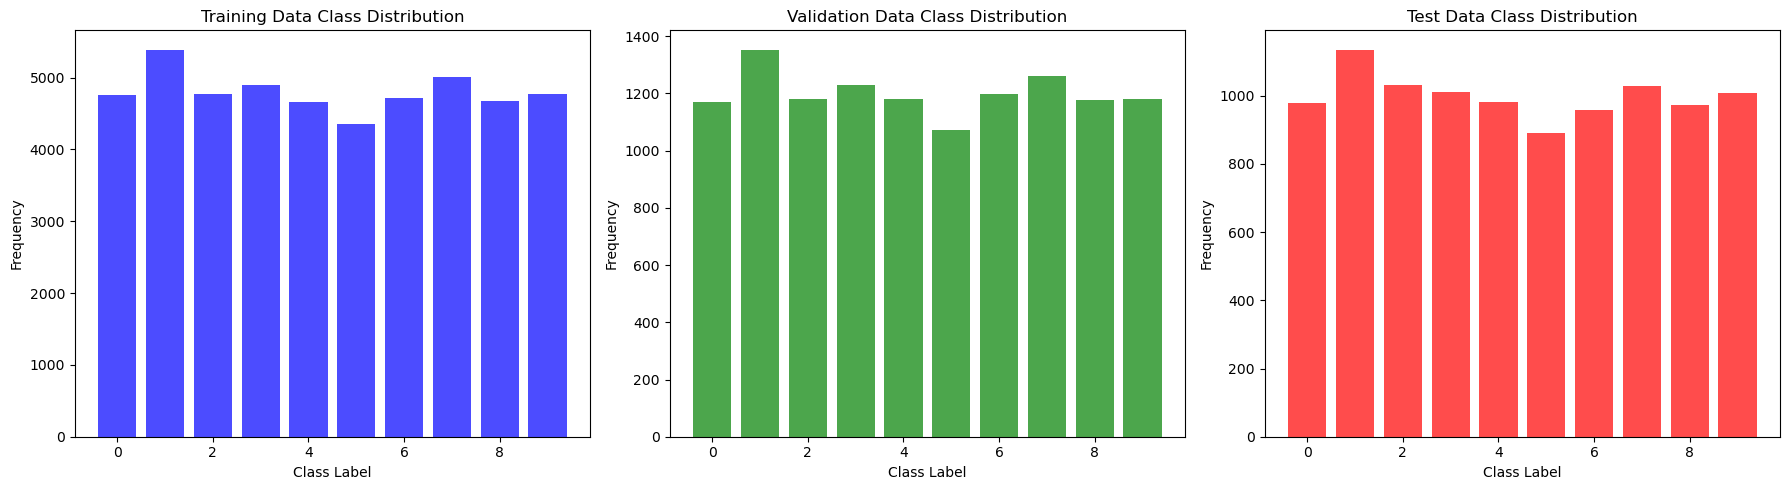

In [4]:
# Function to count occurrences of each class
def get_class_distribution(dataset):
    class_counts = Counter()
    for image, label in dataset:
        class_counts[int(label.numpy())] += 1
    return class_counts

# Get class distributions
train_class_dist = get_class_distribution(ds_train_data)
val_class_dist = get_class_distribution(ds_val_data)
test_class_dist = get_class_distribution(ds_test_data)

# Plot class distributions
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Training data
ax[0].bar(train_class_dist.keys(), train_class_dist.values(), color='blue', alpha=0.7)
ax[0].set_title('Training Data Class Distribution')
ax[0].set_xlabel('Class Label')
ax[0].set_ylabel('Frequency')

# Validation data
ax[1].bar(val_class_dist.keys(), val_class_dist.values(), color='green', alpha=0.7)
ax[1].set_title('Validation Data Class Distribution')
ax[1].set_xlabel('Class Label')
ax[1].set_ylabel('Frequency')

# Test data
ax[2].bar(test_class_dist.keys(), test_class_dist.values(), color='red', alpha=0.7)
ax[2].set_title('Test Data Class Distribution')
ax[2].set_xlabel('Class Label')
ax[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


### 2.3 Preprocesses the images
Here we converts to float32 and normalizes to prepares the MNIST dataset for efficient training.

In [5]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE

BATCH_SIZE = 128

ds_train = (
    ds_train_data
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(info.splits['train'].num_examples)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

ds_val = (
    ds_val_data
    .map(preprocess, AUTOTUNE)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTOTUNE)
)
ds_test = (
    ds_test_data
    .map(preprocess, AUTOTUNE)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTOTUNE)
)

### 2.4 Plot Some Images

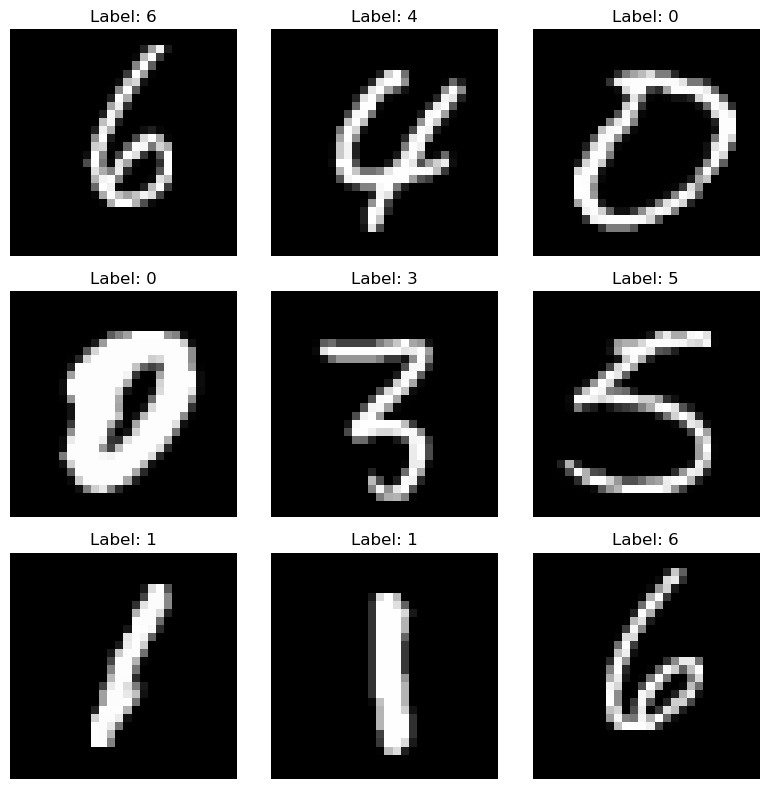

In [6]:
sample_batch = next(iter(ds_train))
images, labels = sample_batch

# Plot images in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].numpy().squeeze(), cmap='gray')  # Convert tensor to NumPy and plot
    ax.set_title(f"Label: {labels[i].numpy()}")
    ax.axis('off')  # Hide axes

plt.tight_layout()
plt.show()

## Step 3: Build and Train the Model
Now, let’s build a simple neural network model and train it on the MNIST dataset.

### 3.1 Define the Model

In [7]:
inputs = layers.Input(shape=(28, 28, 1), name='input')

x = layers.Conv2D(24, kernel_size=(6, 6), strides=1)(inputs)
x = layers.BatchNormalization(scale=False, beta_initializer=Constant(0.01))(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(rate=0.25)(x)

x = layers.Conv2D(48, kernel_size=(5, 5), strides=2)(x)
x = layers.BatchNormalization(scale=False, beta_initializer=Constant(0.01))(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(rate=0.25)(x)

x = layers.Conv2D(64, kernel_size=(4, 4), strides=2)(x)
x = layers.BatchNormalization(scale=False, beta_initializer=Constant(0.01))(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(rate=0.25)(x)

x = layers.Flatten()(x)
x = layers.Dense(200)(x)
x = layers.BatchNormalization(scale=False, beta_initializer=Constant(0.01))(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(rate=0.25)(x)

predications = layers.Dense(num_classes, activation='softmax', name='output')(x)

model = Model(inputs=inputs, outputs=predications)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 23, 23, 24)          │             888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 23, 23, 24)          │              72 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 23, 23, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 23, 23, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 48)          │          28,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 10, 10, 48)          │             144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 10, 10, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 10, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          49,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 4, 64)            │             192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 200)                 │         205,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 200)                 │             600 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 10)                  │           2,010 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 286,970 (1.09 MB)

 Trainable params: 286,298 (1.09 MB)

 Non-trainable params: 672 (2.62 KB)

### 3.2 Training The Model

In [ ]:
lr_decay = lambda epoch: 0.0001 + 0.02 * math.pow(1.0 / math.e, epoch / 3.0)
decay_callback = LearningRateScheduler(lr_decay, verbose=1)

model_history = model.fit(
    ds_train,
    epochs=20,
    validation_data=ds_val,
    callbacks=[decay_callback],
    verbose=1
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0201.
Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 35s 75ms/step - accuracy: 0.9030 - loss: 0.3084 - val_accuracy: 0.9793 - val_loss: 0.0675 - learning_rate: 0.0201

Epoch 2: LearningRateScheduler setting learning rate to 0.014430626211475785.
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 28s 75ms/step - accuracy: 0.9795 - loss: 0.0690 - val_accuracy: 0.9789 - val_loss: 0.0713 - learning_rate: 0.0144

Epoch 3: LearningRateScheduler setting learning rate to 0.01036834238065184.
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 29s 78ms/step - accuracy: 0.9854 - loss: 0.0504 - val_accuracy: 0.9864 - val_loss: 0.0447 - learning_rate: 0.0104

Epoch 4: LearningRateScheduler setting learning rate to 0.007457588823428847.
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.9894 - loss: 0.0336 - val_accuracy: 0.9923 - val_loss: 0.0257 - learning_rate: 0.0075

Epoch 5: LearningRateScheduler setting learning rate to 0.005371942762314537.
Epoc

### 3.3 Evaluate the trained model

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Accuracy
ax[0].plot(model_history.history['accuracy'])
ax[0].plot(model_history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')
ax[0].legend(['train', 'test'])

# Sparse Categorical Crossentropy
ax[1].plot(model_history.history['loss'])
ax[1].plot(model_history.history['val_loss'])
ax[1].set_title('Sparse Categorical Crossentropy')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
ax[1].legend(['train', 'test'])

plt.tight_layout()
plt.show()

### 3.4 Evaluate the Model On Test Data

In [ ]:
test_loss, test_acc = model.evaluate(ds_test, verbose=2)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

## Step 4: Convert the Model to TensorFlow Lite Format
To run the model on mobile, we need to convert it to TensorFlow Lite format.

### 4.1 Convert the Model
TensorFlow Lite models are optimized for performance on mobile and embedded devices. This conversion allows the trained model to run efficiently on an Android device.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('model/mnist_digit_classifier.tflite', 'wb') as f:
    f.write(tflite_model)

### 4.2 Download Model(If you are using colab)

In [ ]:
try:
    from google.colab import files
    files.download('model/mnist_digit_classifier.tflite')
except:
    print("Skip downloading")

## Step 5: Test the TensorFlow Lite Model
### 5.1 Test the Model’s Predictions
You can test your model’s predictions with a few examples.
#### 5.1.1 Prediction Using Random Image In Test dataset


In [ ]:
interpreter = tf.lite.Interpreter(model_path="model/mnist_digit_classifier.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Details:", input_details)
print("Output Details:", output_details)


In [ ]:
sample_batch = next(iter(ds_test))
images, labels = sample_batch
image = images[1].numpy().squeeze()
label = labels[1].numpy()

plt.imshow(image, cmap='gray')  # Convert tensor to NumPy and plot
plt.title(f"Label: {label}")
plt.axis('off') 
plt.tight_layout()
plt.show()

# Add batch dimension and reshape (e.g., for MNIST it should be (1, 28, 28, 1))
image = np.expand_dims(image, axis=0)  # Add batch dimension
image = np.expand_dims(image, axis=-1)  # Add channel dimension if needed

interpreter.set_tensor(input_details[0]['index'], image)
interpreter.invoke()

# Get the output
output = interpreter.get_tensor(output_details[0]['index'])

# Get the predicted class
predicted_class = np.argmax(output)
print("Predicted Class:", predicted_class)
print("Confidence:",output[0][predicted_class])


#### 5.1.2 Prediction Using Actual Image

In [ ]:

# Load the image
image = cv2.imread("images/sample_image_seven.png", cv2.IMREAD_GRAYSCALE)  # Load as grayscale (for MNIST-like models)
image = cv2.resize(image, (28, 28))  # Resize to match model input size
image = image.astype(np.float32) / 255.0  # Normalize between 0 and 1

# Plot the image
plt.imshow(image, cmap="gray")  # Display in grayscale
plt.axis("off")  # Hide axes
plt.show()

# Add batch dimension and reshape (e.g., for MNIST it should be (1, 28, 28, 1))
image = np.expand_dims(image, axis=0)  # Add batch dimension
image = np.expand_dims(image, axis=-1)  # Add channel dimension if needed

interpreter.set_tensor(input_details[0]['index'], image)
interpreter.invoke()

# Get the output
output = interpreter.get_tensor(output_details[0]['index'])

# Get the predicted class
predicted_class = np.argmax(output)
print("Predicted Class:", predicted_class)
print("Confidence:",output[0][predicted_class])

## Step 5: Android Mobile App Integration
While we won't cover the Android Studio code in this codelab, you can proceed with these general steps to integrate the TensorFlow Lite model into an Android app:

- Place the TensorFlow Lite model (mnist_digit_classifier.tflite) in the assets folder of your Android project.
- Use the TensorFlow Lite Android SDK to load and run the model on the device. You can use a DrawView component for users to draw digits and run the   - prediction on the drawn image.
- Display the result on the screen, showing the predicted digit.


## Step 5: Deploy and test the app
Let's deploy the app to an Android Emulator or a physical Android device to test it. Below are the screenshots examples. 

In [ ]:
# Load images
image_paths = ["images/Screenshot_20250207_151351.png", "images/Screenshot_20250207_151503.png", "images/Screenshot_20250207_151605.png"]
images = [Image.open(img) for img in image_paths]

# Display images in a 2x2 grid
fig, axes = plt.subplots(1, 3, figsize=(8, 10))
for ax, img, title in zip(axes.flatten(), images, ["Screenshot 1", "Screenshot 2", "Screenshot 3"]):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()


## Step 7: Advanced - Improve Accuracy
You may have noticed that the model performs well on the test dataset but struggles when recognizing digits you draw. This is a common issue in machine learning—models may generalize poorly to real-world data.

### To-Do List:

#### **Understand the Problem**  
- Test the model with MNIST test images and compare accuracy.  
- Draw your own digits, capture them as images, and test the model.  
- Observe misclassified digits and patterns of errors.  

#### **Apply Data Augmentation**  
- Import `ImageDataGenerator` for augmentation.  
- Define augmentation techniques (rotation, shifting, zooming, etc.).  
- Apply augmentation to the training dataset.  

#### **Retrain the Model**  
- Train the model using augmented data.  
- Validate on the test dataset.  

#### **Evaluate the Model Again**  
- Check the accuracy after retraining.  
- Test with your own handwritten digits again.  
- Compare performance before and after augmentation.  

## 🎉 Congratulations!  

You have gone through an end-to-end journey of training a digit classification model on the MNIST dataset using TensorFlow and deployed the model to a mobile app that uses TensorFlow Lite.  

### **What You Have Learned:**  
✅ Preprocessing and loading the MNIST dataset  
✅ Building and training a neural network with TensorFlow  
✅ Converting the trained model to TensorFlow Lite format  
✅ Deploying the model to an Android mobile app    

### **Next Steps:**  
🔹 Improving model accuracy with data augmentation
🔹 Experiment with different neural network architectures  
🔹 Train with more diverse handwriting datasets  
🔹 Optimize the model for better performance on mobile devices  

🚀 Keep exploring and improving! Happy coding!  


## Appreciation  

Thanks to the amazing tools that made this possible!  

<table>
    <tr>
        <td><img src="images/android_studio.png" alt="Android Studio" width="200"/></td>
        <td><img src="images/tensorflow.png" alt="TensorFlow" width="200"/></td>
        <td><img src="images/tensorflow_lite.png" alt="TensorFlow Lite" width="200"/></td>
    </tr>
    <tr>
        <td align="center"><b>Android Studio</b></td>
        <td align="center"><b>TensorFlow</b></td>
        <td align="center"><b>TensorFlow Lite</b></td>
    </tr>
</table>
